In [1]:
import os, time, random
import numpy as np
import pandas as pd
import cv2, torch
from tqdm.auto import tqdm
import shutil as sh
import re

from IPython.display import Image, clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#%%time
#!git clone https://github.com/ultralytics/yolov5  # clone repo
#!pip install -U pycocotools
#!pip install -qr yolov5/requirements.txt  # install dependencies
#!cp yolov5/requirements.txt ./

In [ ]:
img_h, img_w, num_channels = (380, 676, 3)
df = pd.read_csv('./data/train_solution_bounding_boxes (1).csv')
df.rename(columns={'image':'image_id'}, inplace=True)
df['image_id'] = df['image_id'].apply(lambda x: x.split('.')[0])
print(df[df['image_id']=="vid_4_1000"])

# Annotation

### [ bbox_left , bbox_top , bbox_width , bbox_height , score , object_category , truncation , occlusion]

 - ### bbox_left	     
 
La coordonnée x du coin supérieur gauche de la boîte de délimitation prédite.
 

- ### bbox_top

La coordonnée y du coin supérieur gauche de la boîte englobante de l'objet prédit.

- ### bbox_width

La largeur en pixels de la boîte de délimitation de l'objet prédit.

- ### bbox_height

La hauteur en pixels de la boîte de délimitation de l'objet prédit.

- ### score

Le score du fichier DETECTION indique le degré de confiance de la boîte englobante prédite entourant une instance d'objet.
- 1 indique que le rectangle de délimitation est pris en compte dans l'évaluation, 
- 0 indique que le rectangle englobant sera ignoré.



- ### object_category

La catégorie d'objet indique le type d'objet annoté:
- 0 ignorées
- 1 piéton
- 2 personnes
- 3 bicyclette
- 4 voiture
- 5 fourgon
- 6 camion
- 7 tricycle
- 8 tricycle-auvent
- 9 bus
- 10 moteur
- 11 autres

- ### truncation

Le score dans le fichier de résultat DETECTION doit être défini sur la constante -1.
Le score indique le degré de parties d'objets apparaissant en dehors d'une image 

- 0 pas de troncature (ratio de troncature 0%)
- 1 troncature partielle (ratio de troncature 1% ~ 50%)

- ### occlusion

Le score dans le fichier GROUNDTRUTH indique la fraction d'objets occultés 

- 0 aucune occlusion (rapport d'occlusion de 0 %)
- 1 occlusion partielle (rapport d'occlusion de 1 % ~ 50 %)
- 2 forte occlusion (taux d'occlusion 50 % ~ 100 %)

In [ ]:
f = open('../data/aiskyeye_dataset/VisDrone2019-DET-train/annotations/0000008_02499_d_0000041.txt', 'r')
f.readlines()


In [11]:
chemin_df = "../data/aiskyeye_dataset/VisDrone2019-DET-train/annotations/"
#train_images = os.path.join(train_base_dir, 'images')
train_annotations = os.path.join('../data/aiskyeye_dataset/VisDrone2019-DET-train', 'annotations')
train_annotations_list = sorted(os.listdir(train_annotations))
train_annotations_list = train_annotations_list

df_result = pd.DataFrame(columns=('image_id','bbox_left' , 'bbox_top' , 'bbox_width' , 'bbox_height' , 'score' , 'object_category' , 'truncation' , 'occlusion'))
for i in train_annotations_list:
    fichier = i
    df = open(chemin_df+fichier, "r")
    lines = df.readlines()
    df.close()
    file = fichier.split('.')[0]
    for index, line in enumerate(lines):
        lines[index] = line.strip()
    i = 0
    for line in lines:
        splits = line.split(',')
        df_new_row = pd.DataFrame(data=np.array([[file,splits[0],splits[1],splits[2],splits[3],splits[4],splits[5],splits[6],splits[7]]]), columns=['image_id','bbox_left' , 'bbox_top' , 'bbox_width' , 'bbox_height' , 'score' , 'object_category' , 'truncation' , 'occlusion'])
        df_result = pd.concat([df_result,df_new_row], ignore_index=True)
print(df_result)

                       image_id bbox_left bbox_top bbox_width bbox_height  \
0       0000002_00005_d_0000014       684        8        273         116   
1       0000002_00005_d_0000014       406      119        265          70   
2       0000002_00005_d_0000014       255       22        119         128   
3       0000002_00005_d_0000014         1        3        209          78   
4       0000002_00005_d_0000014       708      471         74          33   
...                         ...       ...      ...        ...         ...   
353545  9999999_00887_d_0000407      1301      840          4           9   
353546  9999999_00887_d_0000407      1321      779         21          23   
353547  9999999_00887_d_0000407      1319      770         12          12   
353548  9999999_00887_d_0000407      1333      766         10           8   
353549  9999999_00887_d_0000407      1341      755         15          13   

       score object_category truncation occlusion  
0          0           

In [12]:
df_result.to_csv('data/dataset_allimgs/dataframe_train.csv')  

In [14]:
# 0 ignorées
# 1 piéton
# 2 personnes
# 3 bicyclette
# 4 voiture
# 5 fourgon
# 6 camion
# 7 tricycle
# 8 tricycle-auvent
# 9 bus
# 10 moteur
# 11 autres
def colors(x):
    return {
        0: (240, 195, 0),
        1: (0,255,0),
        2: (132, 46, 27),
        3: (131, 166, 151),
        4: (0,0,255),
        5: (223, 115, 255),
        6: (255,0,0),
        7: (255, 0, 127),
        8: (112, 41, 99),
        9: (255, 0, 127),
        10:(210, 202, 236),
        11:(0, 86, 27)
    }[x]

In [15]:
def draw_boxes(img, box):
    
    box = [int(x) for x in box.split(',')]
    top_left_x = int(box[0])
    top_left_y = int(box[1])
    
    width = int(box[2])
    height = int(box[3])
    bottom_right_x = top_left_x + width
    bottom_right_y = top_left_y + height
    
    color = colors(int(box[5]))
    
    
    
    
    cv2.rectangle(img, (top_left_x, top_left_y), (bottom_right_x, bottom_right_y),color, 3)

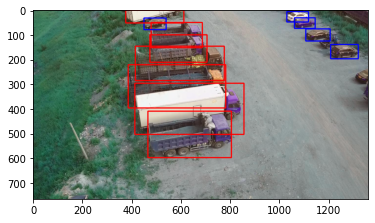

In [18]:
img_path = '../data/aiskyeye_dataset/VisDrone2019-DET-train/images/0000008_02499_d_0000041.jpg'
img_annot= '../data/aiskyeye_dataset/VisDrone2019-DET-train/annotations/0000008_02499_d_0000041.txt'

img = cv2.imread(img_path)
ann = open(img_annot, 'r')

for box in ann.readlines():
    draw_boxes(img, box)
ann.close()
plt.imshow(img)